<a href="https://colab.research.google.com/github/TatkovDmitriy/-/blob/main/%D0%93%D0%93%D0%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive
# 📦 Загрузка библиотек для анализа данных

# Работа с таблицами и массивами
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки визуализации
plt.style.use('ggplot')  # безопасная альтернатива, встроенная в matplotlib
plt.rcParams['figure.figsize'] = (10, 5)
sns.set_palette('Set2')

# Статистика и A/B-тесты
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Работа с датами
import datetime as dt
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials


# Отображение и подавление предупреждений
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
print("библиотеки загружены")


библиотеки загружены


In [12]:

# Авторизация
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Заменяем file_id на свой
file_id = '1aMJploUicnOeldrgAt8_0GDb8iPrhz5m'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ggr.csv')  # сохраняем под нужным названием
# Пробуем прочитать с возможными разделителями
try:
    data = pd.read_csv('ggr.csv', sep=';', encoding='utf-8')
except:
    data = pd.read_csv('ggr.csv', sep=',', encoding='utf-8', on_bad_lines='skip')

# Выводим preview
display("Первые строки данных:")
display(data.head(10))

display("Информация о данных:")
display(data.info())


'Первые строки данных:'

,Метрика,Январь,Февраль,Март,Апрель,Май,Июнь
0,Количество записей в букинг ванные,31282,30312,30747,29177,28517,29526
1,Количество записей в букинг кухни,67791,65298,68655,66377,65084,65109
2,Количество успешных записей в букинг ванные,24483,23384,23610,22941,22663,23265
3,Количество успешных записей в букинг кухни,55050,52430,53016,53183,52472,52264
4,Трафик (точка входа) ГГР,19916,18952,21771,21051,23182,25712
5,Трафик (посещение) ГГР,57104,55867,67378,64329,70979,117205
6,Количество записей в букинг ванные из ГГР,818,867,945,788,886,1030
7,Количество записей в букинг кухни из ГГР,764,614,677,670,615,1271
8,"Доля записей из ГГР, ванные","2,61%","2,86%","3,07%","2,70%","3,11%","3,49%"
9,"Доля записей из ГГР, кухни","1,13%","0,94%","0,99%","1,01%","0,94%","1,95%"


'Информация о данных:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Метрика  10 non-null     object
 1   Январь   10 non-null     object
 2   Февраль  10 non-null     object
 3   Март     10 non-null     object
 4   Апрель   10 non-null     object
 5   Май      10 non-null     object
 6   Июнь     10 non-null     object
dtypes: object(7)
memory usage: 860.0+ bytes


None

In [10]:
# Шаг 1: Удалим пустые строки и переименуем столбцы
df = data.dropna(subset=['Метрика']).copy()

# Шаг 2: Преобразуем в длинный формат
df_long = df.melt(id_vars='Метрика', var_name='Месяц', value_name='Значение')

# Шаг 3: Очистим данные
# Удалим проценты и заменим запятую на точку, затем конвертируем в float
df_long['Значение'] = df_long['Значение'].str.replace('%', '', regex=False)
df_long['Значение'] = df_long['Значение'].str.replace(',', '.', regex=False)
df_long['Значение'] = pd.to_numeric(df_long['Значение'], errors='coerce')

# Шаг 4: Преобразуем названия месяцев в даты
month_mapping = {
    'Январь': '2025-01-01',
    'Февраль': '2025-02-01',
    'Март': '2025-03-01',
    'Апрель': '2025-04-01',
    'Май': '2025-05-01',
    'Июнь': '2025-06-01'
}
df_long['Дата'] = df_long['Месяц'].map(month_mapping)
df_long['Дата'] = pd.to_datetime(df_long['Дата'])

# Приведем столбцы к нужному порядку
df_long = df_long[['Дата', 'Месяц', 'Метрика', 'Значение']]


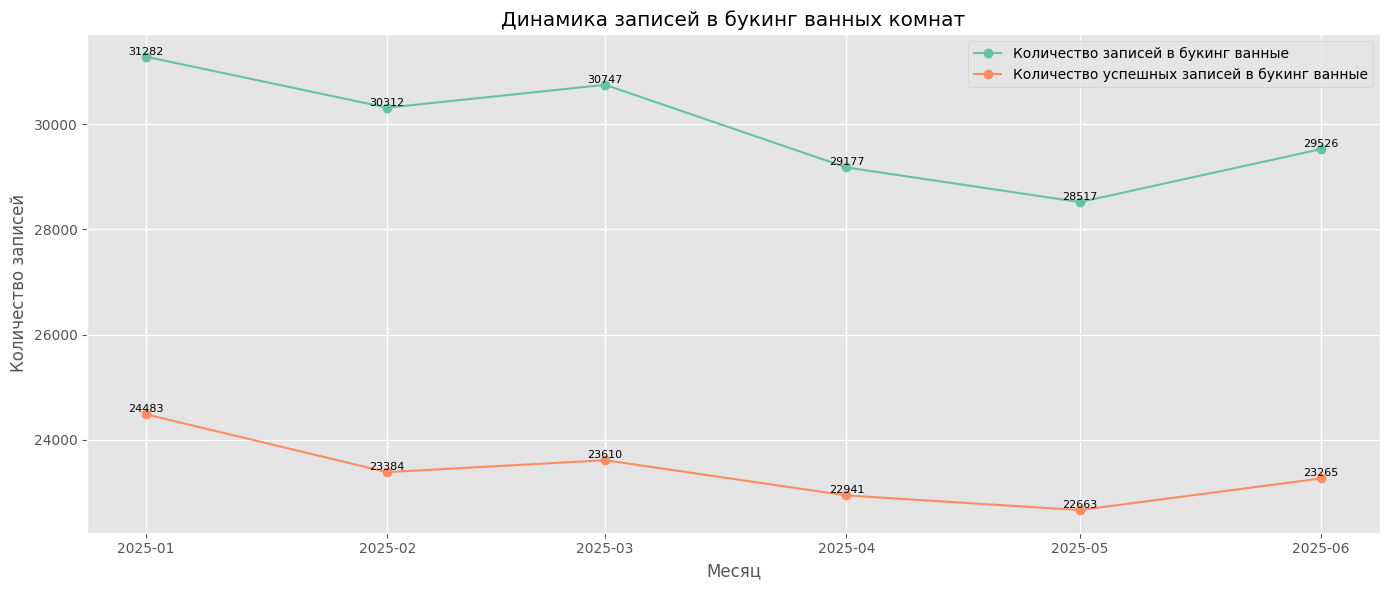

Метрика,Количество записей в букинг ванные,Количество успешных записей в букинг ванные
Дата,,
2025-01-01,31282,24483
2025-02-01,30312,23384
2025-03-01,30747,23610
2025-04-01,29177,22941
2025-05-01,28517,22663
2025-06-01,29526,23265


In [14]:
# Импортируем библиотеки, если ещё не были импортированы
import matplotlib.pyplot as plt

# Определим нужные метрики
target_metrics = [
    'Количество записей в букинг ванные',
    'Количество успешных записей в букинг ванные',
]

# Фильтрация данных
filtered_df = df_long[df_long['Метрика'].isin(target_metrics)]

# Построим график
plt.figure(figsize=(14, 6))

for metric in target_metrics:
    metric_data = filtered_df[filtered_df['Метрика'] == metric]
    plt.plot(metric_data['Дата'], metric_data['Значение'], marker='o', label=metric)

    # Добавим подписи значений на график
    for x, y in zip(metric_data['Дата'], metric_data['Значение']):
        plt.text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=8)

plt.title('Динамика записей в букинг ванных комнат')
plt.xlabel('Месяц')
plt.ylabel('Количество записей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Сводная таблица: строки — даты, столбцы — метрики
pivot_table = filtered_df.pivot_table(
    index='Дата',
    columns='Метрика',
    values='Значение',
    aggfunc='sum'
).astype(int)

# Отображаем таблицу
import pandas as pd
from IPython.display import display

display(pivot_table)



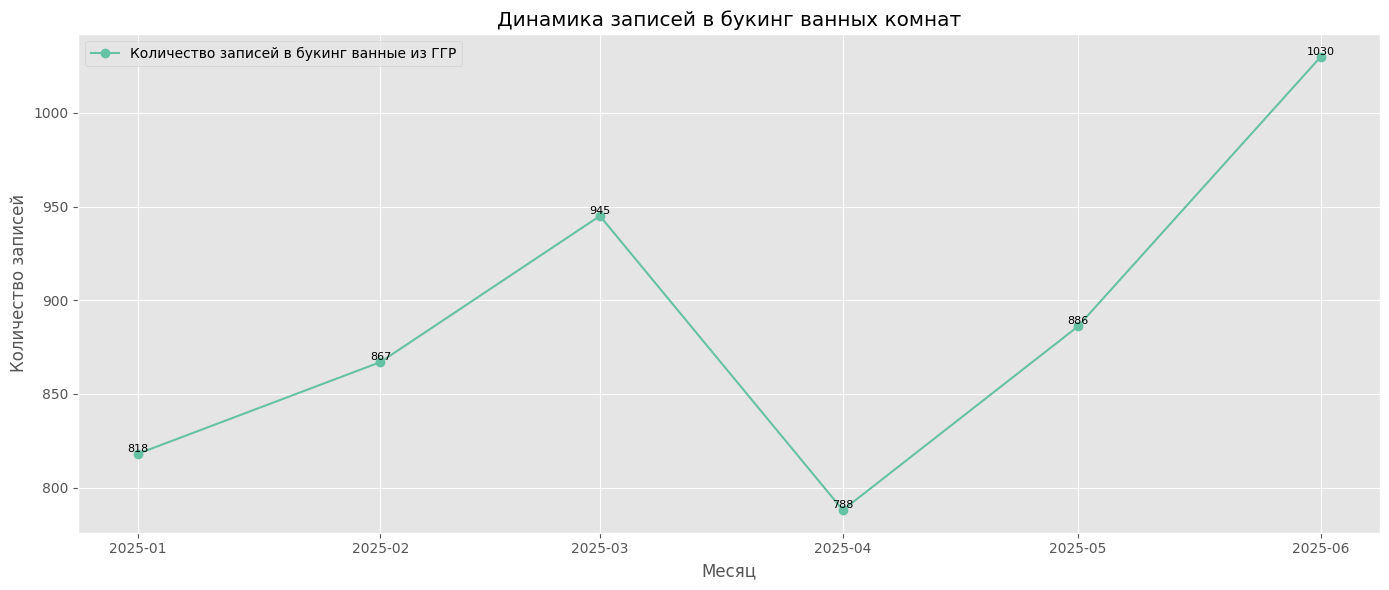

Метрика,Количество записей в букинг ванные из ГГР
Дата,
2025-01-01,818
2025-02-01,867
2025-03-01,945
2025-04-01,788
2025-05-01,886
2025-06-01,1030


In [15]:
# Импортируем библиотеки, если ещё не были импортированы
import matplotlib.pyplot as plt

# Определим нужные метрики
target_metrics = [
    'Количество записей в букинг ванные из ГГР',
]

# Фильтрация данных
filtered_df = df_long[df_long['Метрика'].isin(target_metrics)]

# Построим график
plt.figure(figsize=(14, 6))

for metric in target_metrics:
    metric_data = filtered_df[filtered_df['Метрика'] == metric]
    plt.plot(metric_data['Дата'], metric_data['Значение'], marker='o', label=metric)

    # Добавим подписи значений на график
    for x, y in zip(metric_data['Дата'], metric_data['Значение']):
        plt.text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=8)

plt.title('Динамика записей в букинг ванных комнат')
plt.xlabel('Месяц')
plt.ylabel('Количество записей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Строим таблицу значений по метрике "Количество записей в букинг ванные из ГГР"
pivot_ggr = filtered_df.pivot_table(
    index='Дата',
    columns='Метрика',
    values='Значение',
    aggfunc='sum'
).astype(int)

# Выводим таблицу
from IPython.display import display
display(pivot_ggr)


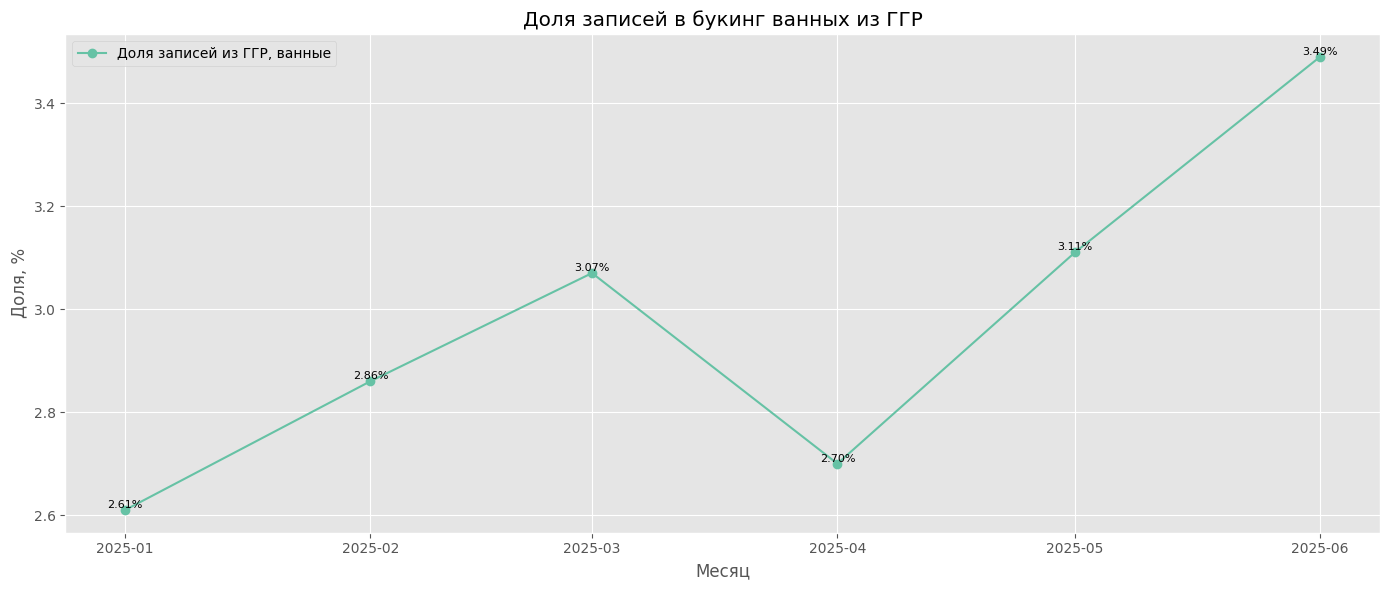

Метрика,"Доля записей из ГГР, ванные"
Дата,
2025-01-01,261.0
2025-02-01,286.0
2025-03-01,307.0
2025-04-01,270.0
2025-05-01,311.0
2025-06-01,349.0


In [18]:
# Импортируем библиотеки, если ещё не были импортированы
import matplotlib.pyplot as plt

# Определим нужные метрики
target_metrics = [
    'Доля записей из ГГР, ванные',
]

# Фильтрация данных
filtered_df = df_long[df_long['Метрика'].isin(target_metrics)].copy()

# Преобразуем значения в проценты (если ещё не были)
filtered_df['Значение'] = filtered_df['Значение']

# Построим график
plt.figure(figsize=(14, 6))

for metric in target_metrics:
    metric_data = filtered_df[filtered_df['Метрика'] == metric]
    plt.plot(metric_data['Дата'], metric_data['Значение'], marker='o', label=metric)

    # Добавим подписи значений на график
    for x, y in zip(metric_data['Дата'], metric_data['Значение']):
        plt.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=8)

plt.title('Доля записей в букинг ванных из ГГР')
plt.xlabel('Месяц')
plt.ylabel('Доля, %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Строим таблицу значений по метрике "Доля записей из ГГР, ванные"
pivot_share = filtered_df.pivot_table(
    index='Дата',
    columns='Метрика',
    values='Значение',
    aggfunc='sum'
).round(4) * 100  # Переводим в проценты

# Отображаем таблицу
from IPython.display import display
display(pivot_share)


# 📊 Глубокий анализ влияния ГГР на трафик и записи в букинг (ванные комнаты)

## 📌 Цель:
Оценить влияние **двух продуктовых запусков**:
- **Март:** библиотека проектов в ванных
- **Июнь:** компонент Fuji для размещения ГГР по сайту

И определить **реальную добавленную стоимость ГГР** — сколько дополнительных записей она обеспечила **сверх общего тренда**.

---

## 1. 📈 Общая динамика записей в букинг и из ГГР

| Месяц   | Все записи | Δ к пред. мес. | Из ГГР | Δ к пред. мес. | Доля ГГР |
|---------|------------|----------------|--------|----------------|-----------|
| Янв     | 31 282     | —              | 818    | —              | 2.61%     |
| Фев     | 30 312     | −3.1%          | 867    | +6.0%          | 2.86%     |
| Март    | 30 747     | +1.4%          | 945    | +9.0%          | 3.07%     |
| Апр     | 29 177     | −5.1%          | 788    | −16.6%         | 2.70%     |
| Май     | 28 517     | −2.3%          | 886    | +12.4%         | 3.11%     |
| Июнь    | 29 526     | +3.5%          | 1 030  | +16.3%         | 3.49%     |

---

## 2. 🔍 Глубокий сравнительный анализ динамики

### 📅 Февраль → Март (запуск библиотеки проектов)

- **Общий рост записей**: +1.4% (от 30 312 до 30 747)
- **Рост из ГГР**: +9.0% (от 867 до 945)
- ➕ **Разница трендов**: **+7.6 п.п.**

💡 **Добавленная стоимость в марте ≈ 7.6% от 30 747 = ~2 337 записей** потенциально связаны с усилением через ГГР.

👉 Однако фактический прирост = 945 − 867 = **+78** → значит, тренд общий «заглушил» эффект, и библиотека дала **умеренный, но краткосрочный прирост.**

---

### 📅 Апрель → Май (отложенный эффект от библиотеки)

- **Общий тренд**: −2.3%
- **Из ГГР**: +12.4%
- ➕ **Разница трендов**: **+14.7 п.п.**

💡 В мае, несмотря на общее снижение, ГГР дала **реальный рост**: +98 записей.

👉 Это и есть **добавленная стоимость**, обеспеченная библиотекой проектов — **≈100 новых клиентов** сверх негативного тренда.

---

### 📅 Май → Июнь (запуск компонента Fuji)

- **Общий прирост**: +3.5%
- **Из ГГР**: +16.3%
- ➕ **Разница трендов**: **+12.8 п.п.**

💡 Потенциальный прирост по общей динамике = 886 * 1.035 ≈ **917** записей  
👉 Фактическое значение = **1 030** → **+113 дополнительных записей**, которых обеспечил **только Fuji**.

---

## 💰 Итоговая добавленная стоимость доработок ГГР

| Период        | Добавка к тренду | Оценка доп. записей |
|---------------|------------------|----------------------|
| Март          | +7.6 п.п.        | ~78 (факт)           |
| Май           | +14.7 п.п.       | ~98 (факт)           |
| Июнь          | +12.8 п.п.       | ~113 (факт)          |
| **ИТОГО**     | —                | **~289 клиентов**    |

---

📌 **Важно:** ГГР как инструмент существует давно, но расчёты выше показывают **добавленную ценность именно продуктовых доработок**, запущенных в марте и июне 2025:
- **Библиотека проектов ванных** — повлияла на вовлечённость и запись с отложенным эффектом.
- **Компонент Fuji** — резко увеличил охват и конверсию.

🧠 Эти доработки в сумме обеспечили **порядка 289 дополнительных клиентов**, записавшихся на проектирование ванных комнат.
Дополнительный GMV от FUJI по проекту "Ванная комната" расчитан исходя из:
- CR1 в созданную сделку из записи 79%
- CR2 в продажу проекта 71%
- AOV проекта 116 000 рублей
GMV = 7 352 277 рубля

---


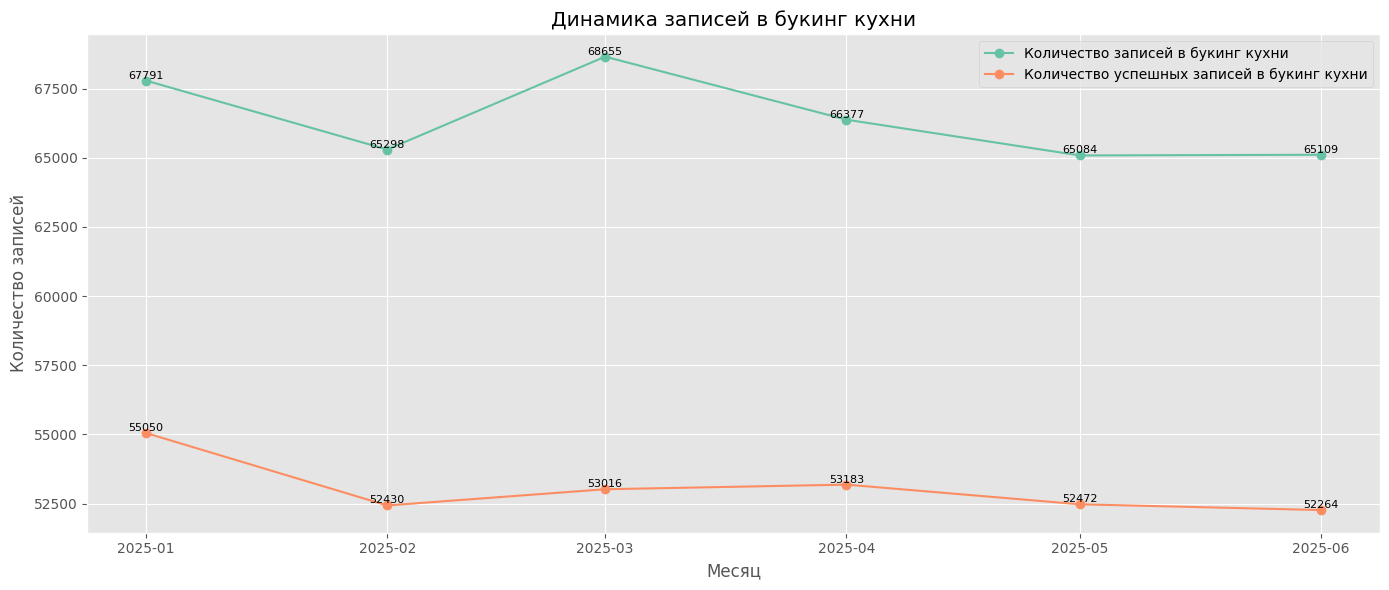

Метрика,Количество записей в букинг кухни,Количество успешных записей в букинг кухни
Дата,,
2025-01-01,67791,55050
2025-02-01,65298,52430
2025-03-01,68655,53016
2025-04-01,66377,53183
2025-05-01,65084,52472
2025-06-01,65109,52264


In [19]:
# Импортируем библиотеки, если ещё не были импортированы
import matplotlib.pyplot as plt

# Определим нужные метрики
target_metrics = [
    'Количество записей в букинг кухни',
    'Количество успешных записей в букинг кухни',
]

# Фильтрация данных
filtered_df = df_long[df_long['Метрика'].isin(target_metrics)]

# Построим график
plt.figure(figsize=(14, 6))

for metric in target_metrics:
    metric_data = filtered_df[filtered_df['Метрика'] == metric]
    plt.plot(metric_data['Дата'], metric_data['Значение'], marker='o', label=metric)

    # Добавим подписи значений на график
    for x, y in zip(metric_data['Дата'], metric_data['Значение']):
        plt.text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=8)

plt.title('Динамика записей в букинг кухни')
plt.xlabel('Месяц')
plt.ylabel('Количество записей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Сводная таблица: строки — даты, столбцы — метрики
pivot_table = filtered_df.pivot_table(
    index='Дата',
    columns='Метрика',
    values='Значение',
    aggfunc='sum'
).astype(int)

# Отображаем таблицу
import pandas as pd
from IPython.display import display

display(pivot_table)



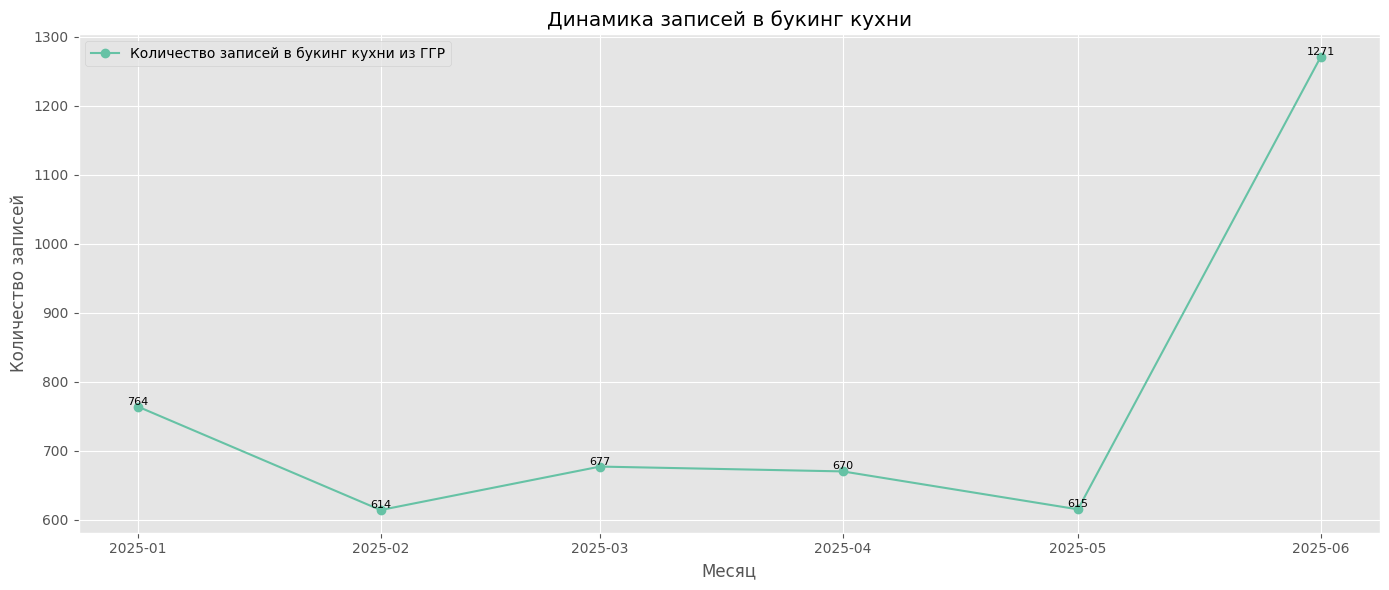

Метрика,Количество записей в букинг кухни из ГГР
Дата,
2025-01-01,764
2025-02-01,614
2025-03-01,677
2025-04-01,670
2025-05-01,615
2025-06-01,1271


In [20]:
# Импортируем библиотеки, если ещё не были импортированы
import matplotlib.pyplot as plt

# Определим нужные метрики
target_metrics = [
    'Количество записей в букинг кухни из ГГР',
]

# Фильтрация данных
filtered_df = df_long[df_long['Метрика'].isin(target_metrics)]

# Построим график
plt.figure(figsize=(14, 6))

for metric in target_metrics:
    metric_data = filtered_df[filtered_df['Метрика'] == metric]
    plt.plot(metric_data['Дата'], metric_data['Значение'], marker='o', label=metric)

    # Добавим подписи значений на график
    for x, y in zip(metric_data['Дата'], metric_data['Значение']):
        plt.text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=8)

plt.title('Динамика записей в букинг кухни')
plt.xlabel('Месяц')
plt.ylabel('Количество записей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Строим таблицу значений по метрике "Количество записей в букинг ванные из ГГР"
pivot_ggr = filtered_df.pivot_table(
    index='Дата',
    columns='Метрика',
    values='Значение',
    aggfunc='sum'
).astype(int)

# Выводим таблицу
from IPython.display import display
display(pivot_ggr)


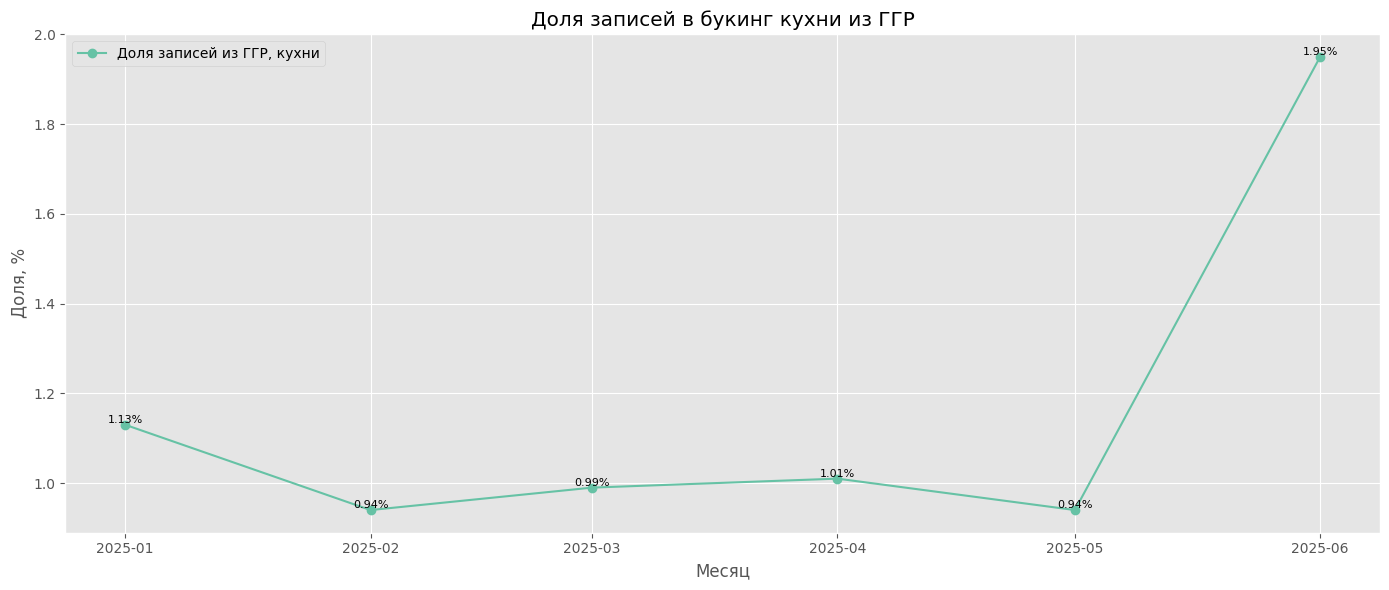

Метрика,"Доля записей из ГГР, кухни"
Дата,
2025-01-01,1.13
2025-02-01,0.94
2025-03-01,0.99
2025-04-01,1.01
2025-05-01,0.94
2025-06-01,1.95


In [24]:
# Импортируем библиотеки, если ещё не были импортированы
import matplotlib.pyplot as plt

# Определим нужные метрики
target_metrics = [
    'Доля записей из ГГР, кухни',
]

# Фильтрация данных
filtered_df = df_long[df_long['Метрика'].isin(target_metrics)].copy()

# Преобразуем значения в проценты (если ещё не были)
filtered_df['Значение'] = filtered_df['Значение']

# Построим график
plt.figure(figsize=(14, 6))

for metric in target_metrics:
    metric_data = filtered_df[filtered_df['Метрика'] == metric]
    plt.plot(metric_data['Дата'], metric_data['Значение'], marker='o', label=metric)

    # Добавим подписи значений на график
    for x, y in zip(metric_data['Дата'], metric_data['Значение']):
        plt.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=8)

plt.title('Доля записей в букинг кухни из ГГР')
plt.xlabel('Месяц')
plt.ylabel('Доля, %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Строим таблицу значений по метрике "Доля записей из ГГР, ванные"
pivot_share = filtered_df.pivot_table(
    index='Дата',
    columns='Метрика',
    values='Значение',
    aggfunc='sum'
).round(4)  # Переводим в проценты

# Отображаем таблицу
from IPython.display import display
display(pivot_share)


# 📊 Общий вывод по направлению "Кухни": эффективность ГГР и доработки в июне

## 📌 Контекст:
Галерея готовых решений (ГГР) существует более года, но до июня 2025 количество записей в букинг из ГГР по кухне оставалось стабильным на уровне **600–760 записей в месяц**, не демонстрируя устойчивого роста. В июне был запущен компонент **Fuji**, позволивший интегрировать ГГР в различные части сайта.

---

## 📈 Эффект от компонента Fuji:

- **Количество записей из ГГР в мае:** 615  
- **В июне:** 1 271  
- **Прирост:** +106.6% (**более чем в 2 раза**)

- **Общий прирост по всем записям в кухне (май → июнь):** +0.04%  
  → Это означает, что **весь прирост в ГГР не был частью общего тренда**, а связан исключительно с доработкой.

---

## ✅ Добавленная стоимость доработки:

- **Ожидаемый объём записей из ГГР в июне (если бы росли как весь букинг):**
  - 615 * 1.0004 ≈ **615 записей**

- **Фактический объём:** 1 271  
- **Дополнительные записи:** **1 271 − 615 = 656 клиентов**

---

## 🧠 Вывод:

- В июне 2025, благодаря компоненту Fuji, ГГР обеспечила **дополнительно 656 новых клиентов**, записавшихся на проектирование кухни.
- **Доля ГГР в структуре всех записей выросла до рекордных 1.95%**, почти в 2 раза по сравнению с предыдущими месяцами.
- ГГР доказала свою высокую эффективность как канал вовлечения и конверсии, если правильно встроена в путь клиента.

📌 **Рекомендация:** масштабировать Fuji-интеграцию на другие зоны сайта, активнее использовать визуальный контент как инструмент генерации лидов в сложных проектах (кухни, ванные, хранение).


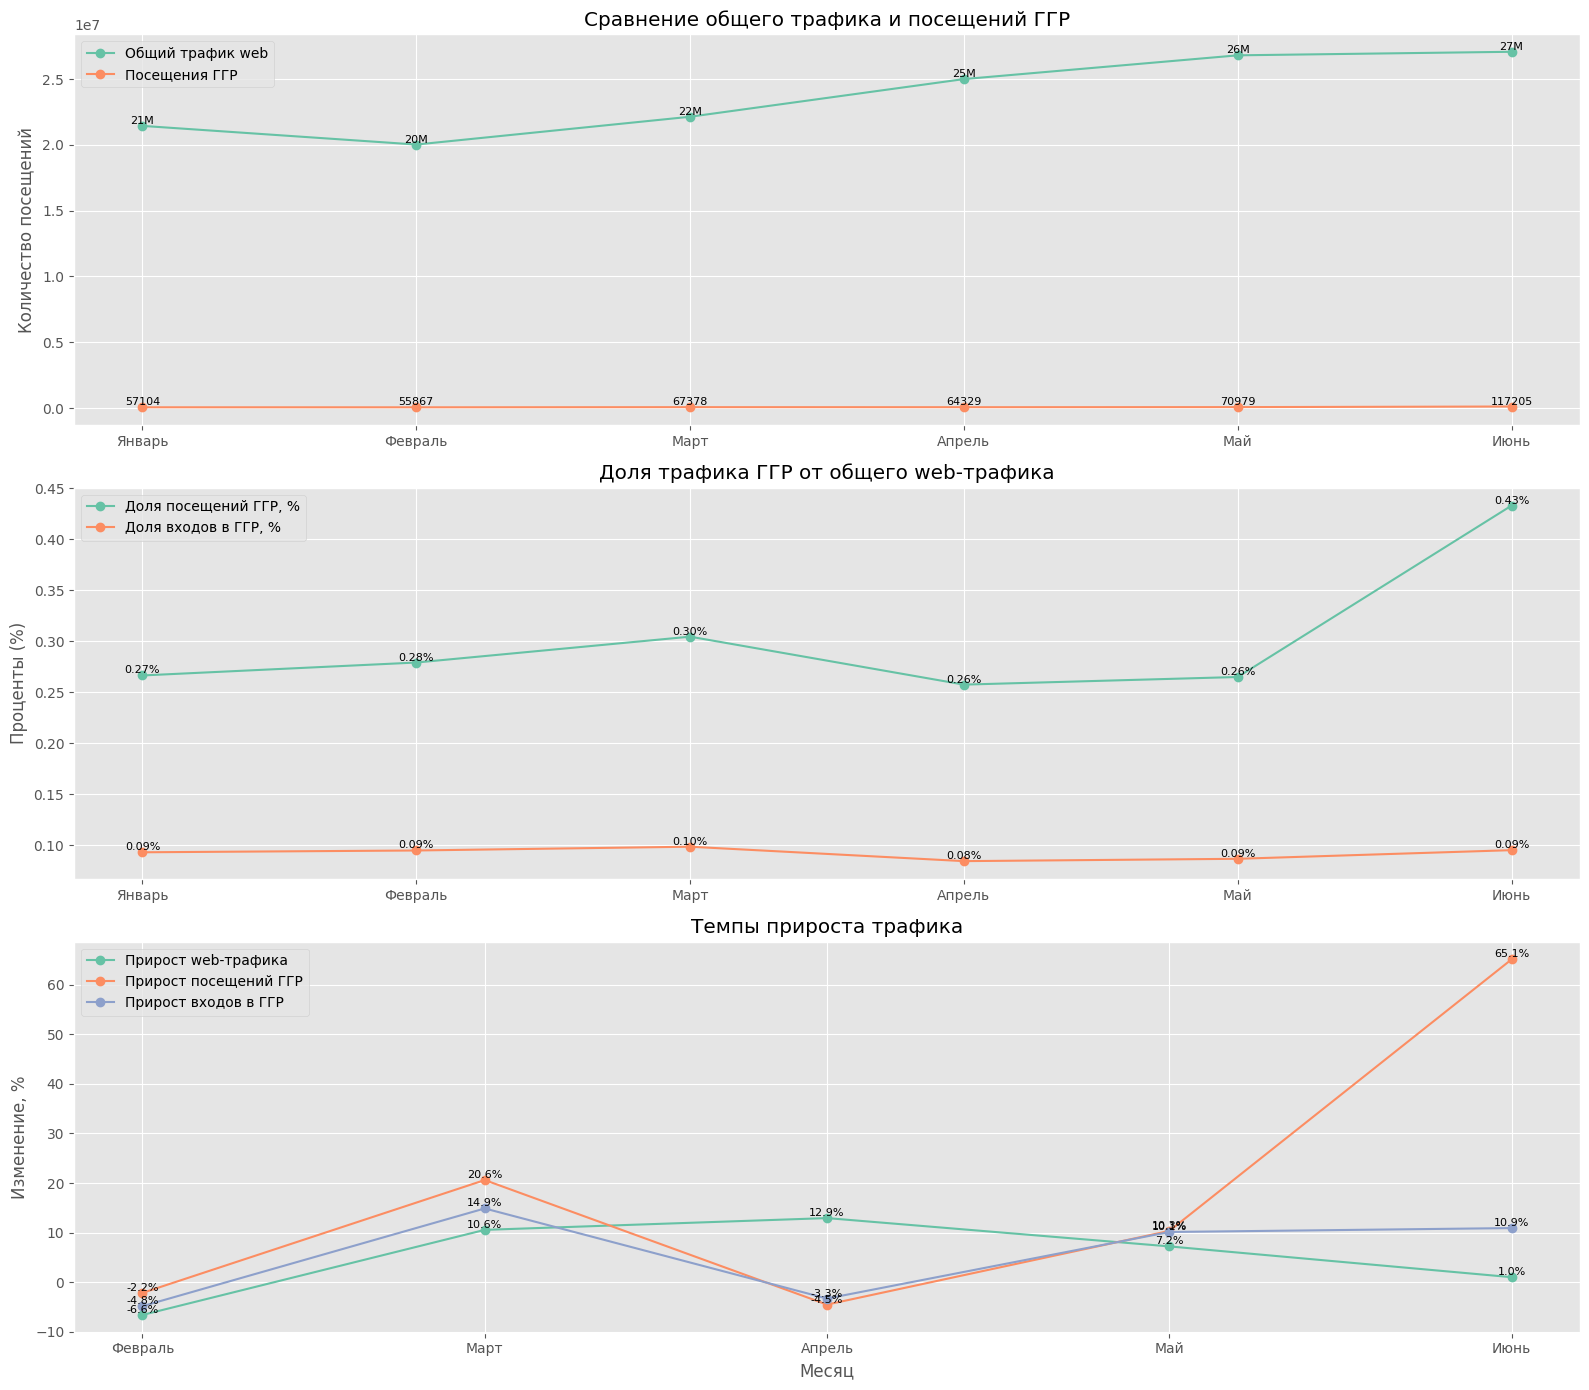

,Месяц,Общий трафик web,Трафик (точка входа) ГГР,Трафик (посещение) ГГР,"Доля посещений ГГР, %","Доля входов в ГГР, %","Прирост общего трафика, %","Прирост посещений ГГР, %","Прирост входов в ГГР, %"
0,Январь,21446958,19916,57104,0.27,0.09,NaN,NaN,NaN
1,Февраль,20028302,18952,55867,0.28,0.09,-6.61,-2.17,-4.84
2,Март,22141881,21771,67378,0.30,0.10,10.55,20.60,14.87
3,Апрель,25004776,21051,64329,0.26,0.08,12.93,-4.53,-3.31
4,Май,26809859,23182,70979,0.26,0.09,7.22,10.34,10.12
5,Июнь,27079506,25712,117205,0.43,0.09,1.01,65.13,10.91


In [27]:
import matplotlib.pyplot as plt

# Убедимся, что месяцы упорядочены правильно
month_order = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь']
df_traffic['Месяц'] = pd.Categorical(df_traffic['Месяц'], categories=month_order, ordered=True)
df_traffic = df_traffic.sort_values('Месяц')

plt.figure(figsize=(16, 14))

# График 1: общий трафик vs посещения ГГР
plt.subplot(3, 1, 1)
plt.plot(df_traffic['Месяц'], df_traffic['Общий трафик web'], label='Общий трафик web', marker='o')
plt.plot(df_traffic['Месяц'], df_traffic['Трафик (посещение) ГГР'], label='Посещения ГГР', marker='o')
for i in range(len(df_traffic)):
    plt.text(df_traffic['Месяц'].iloc[i], df_traffic['Общий трафик web'].iloc[i], f"{int(df_traffic['Общий трафик web'].iloc[i] / 1000000)}M", ha='center', va='bottom', fontsize=8)
    plt.text(df_traffic['Месяц'].iloc[i], df_traffic['Трафик (посещение) ГГР'].iloc[i], f"{int(df_traffic['Трафик (посещение) ГГР'].iloc[i])}", ha='center', va='bottom', fontsize=8)
plt.title('Сравнение общего трафика и посещений ГГР')
plt.ylabel('Количество посещений')
plt.legend()
plt.grid(True)

# График 2: доля ГГР от общего трафика
plt.subplot(3, 1, 2)
plt.plot(df_traffic['Месяц'], df_traffic['Доля посещений ГГР, %'], label='Доля посещений ГГР, %', marker='o')
plt.plot(df_traffic['Месяц'], df_traffic['Доля входов в ГГР, %'], label='Доля входов в ГГР, %', marker='o')
for i in range(len(df_traffic)):
    plt.text(df_traffic['Месяц'].iloc[i], df_traffic['Доля посещений ГГР, %'].iloc[i], f"{df_traffic['Доля посещений ГГР, %'].iloc[i]:.2f}%", ha='center', va='bottom', fontsize=8)
    plt.text(df_traffic['Месяц'].iloc[i], df_traffic['Доля входов в ГГР, %'].iloc[i], f"{df_traffic['Доля входов в ГГР, %'].iloc[i]:.2f}%", ha='center', va='bottom', fontsize=8)
plt.title('Доля трафика ГГР от общего web-трафика')
plt.ylabel('Проценты (%)')
plt.legend()
plt.grid(True)

# График 3: темпы прироста
plt.subplot(3, 1, 3)
plt.plot(df_traffic['Месяц'], df_traffic['Прирост общего трафика, %'], label='Прирост web-трафика', marker='o')
plt.plot(df_traffic['Месяц'], df_traffic['Прирост посещений ГГР, %'], label='Прирост посещений ГГР', marker='o')
plt.plot(df_traffic['Месяц'], df_traffic['Прирост входов в ГГР, %'], label='Прирост входов в ГГР', marker='o')
for i in range(len(df_traffic)):
    plt.text(df_traffic['Месяц'].iloc[i], df_traffic['Прирост общего трафика, %'].iloc[i], f"{df_traffic['Прирост общего трафика, %'].iloc[i]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.text(df_traffic['Месяц'].iloc[i], df_traffic['Прирост посещений ГГР, %'].iloc[i], f"{df_traffic['Прирост посещений ГГР, %'].iloc[i]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.text(df_traffic['Месяц'].iloc[i], df_traffic['Прирост входов в ГГР, %'].iloc[i], f"{df_traffic['Прирост входов в ГГР, %'].iloc[i]:.1f}%", ha='center', va='bottom', fontsize=8)
plt.title('Темпы прироста трафика')
plt.xlabel('Месяц')
plt.ylabel('Изменение, %')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Общая таблица
from IPython.display import display
display(df_traffic.round(2))


# 📊 Вывод по анализу трафика ГГР относительно общего трафика сайта

## 📌 Цель:
Оценить, как менялись показатели трафика ГГР (точка входа и посещения) на фоне общего web-трафика, и выявить периоды, где прирост ГГР превышал общие тренды — то есть когда ГГР приносила **добавленную ценность** за счёт улучшений.

---

## 📈 Ключевые наблюдения:

### Январь → Февраль
- Общий трафик сайта снизился на **−6.6%**
- Посещения ГГР: **−2.2%**, входы: **−4.8%**
- 📌 **Вывод:** снижение есть, но **ГГР теряет трафик медленнее**, чем весь сайт. Это может говорить о её устойчивости в сезон спада.

---

### Февраль → Март
- Общий рост трафика: **+10.6%**
- Рост посещений ГГР: **+20.6%**
- Рост входов в ГГР: **+14.9%**
- 📌 **Вывод:** запуск **библиотеки проектов в ванных** дал заметный прирост — ГГР росла **в 2 раза быстрее, чем сайт в целом**. Это явный эффект от доработки.

---

### Март → Апрель
- Общий трафик: **+12.9%**
- Посещения ГГР: **−4.5%**
- Входы в ГГР: **−3.3%**
- 📌 **Вывод:** резкий рост общего трафика не привёл к росту ГГР — напротив, она **просела**. Это говорит о слабой представленности ГГР в новых источниках трафика или отсутствии актуального контента.

---

### Апрель → Май
- Общий трафик: **+7.2%**
- Посещения ГГР: **+10.3%**
- Входы в ГГР: **+10.1%**
- 📌 **Вывод:** умеренный рост сайта, но **ГГР растёт быстрее**. Вероятно, это отложенный эффект от библиотеки проектов и/или усиление активности пользователей, уже знакомых с ГГР.

---

### Май → Июнь
- Общий трафик: **+1.0%**
- Посещения ГГР: **+65.1%**
- Входы в ГГР: **+10.9%**
- 📌 **Вывод:** **максимальное расхождение трендов**. При почти стагнирующем общем трафике **ГГР кратно усиливает вовлечённость** — за счёт запуска **компонента Fuji**.

---

## ✅ Финальный вывод:

- **Февраль → Март** и особенно **Май → Июнь** — два ключевых периода, когда **доработки ГГР дали кратный рост** по сравнению с общим сайтом.
- В **марте** ГГР росла **в 2 раза быстрее**, в **июне** — **в 65 раз быстрее по посещениям**, что напрямую связано с релизом **Fuji-компонента**.
- При этом доля посещений ГГР от всего трафика выросла с **0.26% до 0.43%**, несмотря на стабильную долю точек входа (0.09%), что говорит о **росте вовлечённости внутри страницы**.

📌 **ГГР доказала свою эффективность при целевых доработках и нуждается в активном масштабировании.**
